In [1]:
import pandas as pd
import numpy as np
import pystan
from matplotlib import pyplot as plt
plt.style.use('fr_sparse')

## Vote shares by authority in the 2018, 2014, 2012 and 2011 local elections

In [2]:
def proportionise(df):
    return df.div(df.sum(axis=1), axis=0)

url_2018 = "https://candidates.democracyclub.org.uk/media/csv-archives/results-2018-05-03.csv"
at_url = "http://www.andrewteale.me.uk/pdf/{0}/{0}_results.zip"
at_colnames = ['ward', 'council', 'candidate', 'party_at', 'votes', 'elected']
dc_ballot_colnames = ['election_type', 'council', 'ward', 'date', '???']
final_colnames = ['council', 'ward', 'year', 'party', 'votes']

at_party_names = {
    'Lab': 'labour',
    'C': 'conservative',
    'LD': 'libdem',
    'UKIP': 'ukip',
    'Grn': 'green'
}
dc_party_names = {
    'Labour Party': 'labour',
    'Labour and Co-operative Party': 'labour',
    'Conservative and Unionist Party': 'conservative',
    'Liberal Democrats': 'libdem',
    'UK Independence Party (UKIP)': 'ukip',
    'Green Party': 'green'
}

results_2018 = pd.read_csv(url_2018, header=1).assign(year=2018)
info_2018 = pd.DataFrame.from_records(results_2018['ballot_paper_id'].str.split('.').tolist())
info_2018.columns = dc_ballot_colnames
info_2018['council'] = info_2018['council'].str.replace('-', ' ')
info_2018['ward'] = info_2018['ward'].str.replace('-', ' ')

results_2018 = results_2018.join(info_2018).loc[lambda df: df['election_type'] == 'local']
results_2018['party'] = results_2018['party_name'].map(dc_party_names).fillna('other')
results_2018['votes'] = results_2018['ballots_cast'].astype(int)
results_2018['candidate'] = results_2018['person_name']

results_at = pd.concat([
    pd.read_csv(at_url.format(str(year)), header=None, names=at_colnames, skiprows=None if year != 2014 else 1)
    .assign(year=year,
            party=lambda df: df['party_at'].map(at_party_names).fillna('other'),
            ward=lambda df: df['ward'].str.lower(),
            council=lambda df: df['council'].str.lower(),
            votes=lambda df: df['votes'].astype(int))
    for year in [2011, 2012, 2014]
])

results = pd.concat([results_at[final_colnames], results_2018[final_colnames]])
vote_shares = results.groupby(['year', 'council', 'party'])['votes'].sum().unstack().pipe(proportionise).fillna(0)
vote_shares['lab_2p'] = vote_shares['labour'] / (vote_shares['labour'] + vote_shares['conservative'])

vote_shares.head()

party              conservative     green    labour    libdem     other  \
year council                                                              
2011 allerdale         0.191998  0.020106  0.523311  0.024760  0.239824   
     amber valley      0.476249  0.025643  0.385513  0.045206  0.067389   
     arun              0.611590  0.000000  0.126665  0.176513  0.036395   
     ashfield          0.111657  0.008944  0.452936  0.256003  0.167465   
     ashford           0.468302  0.024342  0.105387  0.104058  0.279617   

party                  ukip    lab_2p  
year council                           
2011 allerdale     0.000000  0.731587  
     amber valley  0.000000  0.447355  
     arun          0.048837  0.171573  
     ashfield      0.002995  0.802235  
     ashford       0.018294  0.183701

In [3]:
vote_shares.reset_index().to_csv("~/Downloads/vote_shares.csv")

## Change in vote share 2014-2018 by party (where available)

party,conservative_change,green_change,labour_change,libdem_change,other_change,ukip_change,lab_2p_change
council,,,,,,,
worthing,0.097181,-0.065266,0.227648,0.007908,0.000000,-0.267470,0.184585
adur,0.071782,0.022573,0.193580,-0.038967,0.004814,-0.253782,0.149107
tunbridge wells,-0.028687,-0.016725,0.080279,0.089568,0.103472,-0.227908,0.106738
newham,-0.087681,0.021565,0.085869,0.018239,-0.024492,-0.013500,0.097174
west oxfordshire,-0.038830,-0.021203,0.078158,0.108583,0.000424,-0.127133,0.093803


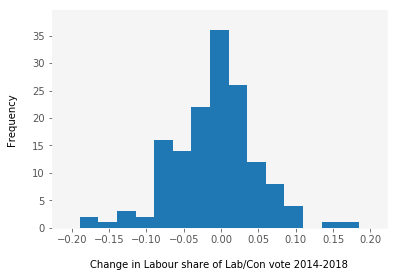

In [4]:
both = vote_shares.loc[2014:2018].unstack(level=0).dropna().stack().swaplevel().sort_index()
vote_share_change = (both.loc[2018] - both.loc[2014]).add_suffix("_change")
display(vote_share_change.sort_values('lab_2p_change', ascending=False).head())
hist = plt.hist(vote_share_change['lab_2p_change'], bins=15)
plt.xlabel("Change in Labour share of Lab/Con vote 2014-2018")
plt.ylabel("Frequency")

In [5]:
vote_share_change.to_csv("~/Downloads/vote_share_change_2014_2018.csv")

## Median annual pay 2012-2017

In [6]:
earnings = (
    # download the very big csv from here: https://download.beta.ons.gov.uk/downloads/datasets/ashe-table-8-earnings/editions/time-series/versions/1.csv
    # I got a 'permission denied' message from the ons website when I tried to read it with `read_excel` :(
    pd.read_csv("../data/data_in/earning_data.csv")
    .loc[lambda df: (df['Geography'].str.lower().isin(vote_share_change.index))
         & (df['Sex_codelist'] == 'all')
         & (df['Statistics_codelist'] == 'median')
         & (df['Workingpattern_codelist'] == 'all')
         & (df['Earnings'] == 'Annual pay - Gross')]
    .assign(authority=lambda df: df['Geography'].str.lower())
    .set_index(['authority', 'Time'])['V4_2']
    .unstack()
)
earnings.sort_values(2017, ascending=True).head()

/Users/teddy/.pyenv/versions/3.6.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time,2012,2013,2014,2015,2016,2017
authority,,,,,,
great yarmouth,17598,18357,17813,17445,18502,17415
craven,19135,18340,17629,20046,18372,17469
north east lincolnshire,19445,18314,18222,18171,19151,18310
blackburn with darwen,16959,18099,17436,18393,19295,19191
hyndburn,17609,17913,17637,19867,20259,19556


In [7]:
earnings.to_csv("~/Downloads/median_annual_pay.csv")

## Map of local authorities to regions

Useful for hierarchical models...

In [8]:
region_lookup_url = "http://geoportal1-ons.opendata.arcgis.com/datasets/c457af6314f24b20bb5de8fe41e05898_0.csv"
authority_to_region = (
    pd.read_csv(region_lookup_url)
    .assign(authority=lambda df: df['LAD17NM'].str.lower(),
            region=lambda df: df['RGN17NM'].str.lower())
    .set_index('authority')
    ['region']
)
authority_to_region.head()

authority
city of london          london
barking and dagenham    london
barnet                  london
bexley                  london
brent                   london
Name: region, dtype: object

In [9]:
authority_to_region.reset_index().to_csv("~/Downloads/authority_to_region.csv")

## Housing waiting lists 2010 vs 2017

In [10]:
waiting_list_url = "https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/674350/LT_600.xlsx"

waiting_list = (
    pd.read_excel(waiting_list_url, header=0, skiprows=3, usecols=[4, 19, 26])
    .dropna()
    .rename(columns={'Lower and Single Tier Authority Data': 'authority'})
    .assign(authority=lambda df: df['authority'].str.lower())
    .set_index('authority')
    .replace('..', np.nan)
    .astype(float)
    .assign(change=lambda df: df[2017] - df[2010],
            ratio=lambda df: df[2017] / df[2010])

)

In [11]:
waiting_list.reset_index().to_csv("~/Downloads/housing_waiting_lists_2010_2017")

## Leave vote share in the referendum

In [12]:
eu_ref_url = "https://www.electoralcommission.org.uk/__data/assets/file/0014/212135/EU-referendum-result-data.csv" 

leave_vote_share = (
    pd.read_csv(eu_ref_url)
    .assign(authority=lambda df: df['Area'].str.lower())
    .groupby('authority')['Pct_Leave'].first()
    .rename('leave_vote_share')
)

In [13]:
leave_vote_share.reset_index().to_csv("~/Downloads/leave_vote_share_by_authority.csv")

## 2016 population estimates by local authority 

These might be useful for scaling some of the other statistics.

In [14]:
# Another access denied - has to be downloaded from here: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental
population_sheet_path = "../data/data_in/population_estimates.xls"

population_by_ward = (pd.read_excel(population_sheet_path, sheet_name="Mid-2016 Persons", skiprows=4, header=0)
                      .assign(authority=lambda df: df['Local Authority'].str.lower())
                      .drop('Local Authority', axis=1))

total_population_by_authority = (population_by_ward
                                 .groupby('authority')['All Ages'].sum()
                                 .astype(int)
                                 .rename('population'))
total_population_by_authority.sort_values(ascending=False).head()

authority
birmingham    1124569
leeds          781743
sheffield      575424
cornwall       553687
manchester     541263
Name: population, dtype: int64

In [15]:
total_population_by_authority.reset_index().to_csv("~/Downloads/population_estimate_2016_by_local_authority.csv")

In [16]:
def stanify_series(s):
    return pd.Series(s.factorize()[0] + 1, index=s.index)

# design matrix
dm = (
    vote_share_change
    .join(waiting_list.add_prefix('waiting_list_'), how='left')
    .join(total_population_by_authority, how='left')
    .join(earnings.add_prefix('median_income_'), how='left')
    .join(authority_to_region)
    .join(leave_vote_share)
    .assign(region_stan=lambda df: stanify_series(df['region']))
    .dropna()
)
dm.head()

,conservative_change,green_change,labour_change,libdem_change,other_change,ukip_change,lab_2p_change,waiting_list_2010,waiting_list_2017,waiting_list_change,...,population,median_income_2012,median_income_2013,median_income_2014,median_income_2015,median_income_2016,median_income_2017,region,leave_vote_share,region_stan
council,,,,,,,,,,,,,,,,,,,,,
adur,0.071782,0.022573,0.193580,-0.038967,0.004814,-0.253782,0.149107,1603.0,769.0,-834.0,...,63506.0,20004,19257,20788,21377,20611,20312,south east,54.57,1
amber valley,0.162960,0.057917,0.033526,0.008095,-0.009576,-0.252923,-0.084903,2639.0,2324.0,-315.0,...,124645.0,20676,21842,22154,21380,22780,23361,east midlands,60.28,2
barking and dagenham,0.124015,-0.010849,0.075145,-0.016585,-0.017304,-0.154422,-0.099980,11376.0,6795.0,-4581.0,...,206460.0,23975,24920,23228,23901,23601,24593,london,62.44,3
barnet,0.051622,-0.048938,0.009211,0.010025,-0.001740,-0.020180,-0.023336,15166.0,2683.0,-12483.0,...,386083.0,27299,27435,25785,26099,26000,28160,london,37.77,3
barnsley,0.051568,0.037507,0.072205,0.092784,-0.106310,-0.147754,-0.030928,7215.0,5472.0,-1743.0,...,241218.0,20072,20376,19925,20573,19886,20541,yorkshire and the humber,68.31,4


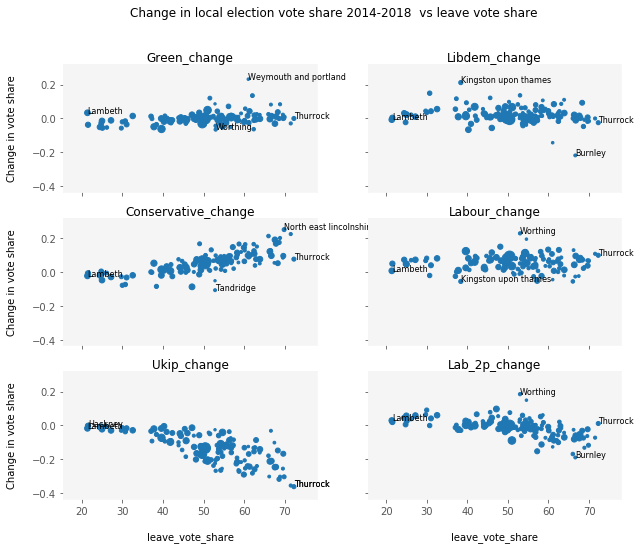

In [17]:
f, axes = plt.subplots(3, 2, figsize=[10, 8], sharey=True, sharex=True)
axes = axes.ravel()
x_col = 'leave_vote_share'

f.suptitle("Change in local election vote share 2014-2018  vs {}".format(x_col.replace('_', ' ')))

for ax, y_col in zip(axes, ['green_change', 'libdem_change', 'conservative_change', 
                            'labour_change', 'ukip_change', 'lab_2p_change']):
    ax.scatter(dm[x_col], dm[y_col], s=dm['population']/10000)
    extremes = (list(dm.sort_values(y_col)[y_col].dropna().iloc[np.r_[0, -1]].index)
                + list(dm.sort_values(x_col)[x_col].dropna().iloc[np.r_[0, -1]].index))
    for i, r in dm.loc[extremes].iterrows():
        if all(np.isfinite(dm.loc[i, [x_col, y_col]].astype(float))):
            ax.text(dm.loc[i, x_col], dm.loc[i, y_col], i.capitalize(), fontsize=8)

    ax.set_title(y_col.capitalize(), y=0.8)
    if ax in [axes[0], axes[2], axes[4]]:
        ax.set_ylabel("Change in vote share".format(y_col))
axes[4].set_xlabel("{}".format(x_col))
axes[5].set_xlabel("{}".format(x_col))
# plt.tight_layout()

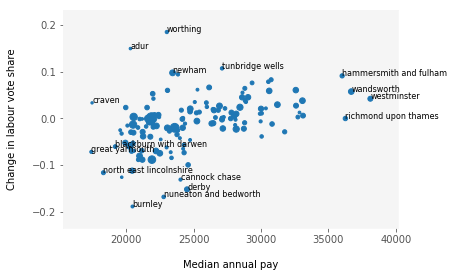

In [18]:
t = vote_share_change.join(earnings[2017].rename('earnings')).join(total_population_by_authority)

plt.scatter(t['earnings'], t['lab_2p_change'], s=t['population']/10000)
extremes = (list(t.sort_values('earnings').dropna().iloc[np.r_[0:4, -4:0]].index)
            + list(t.sort_values('lab_2p_change').dropna().iloc[np.r_[0:4, -4:0]].index))
for i, r in t.loc[extremes].iterrows():
    if all(np.isfinite(t.loc[i, ['earnings', 'lab_2p_change']].astype(float))):
        plt.text(t.loc[i, 'earnings'], t.loc[i, 'lab_2p_change'], i, fontsize=8)


plt.xlabel("Median annual pay")
plt.ylabel("Change in labour vote share")

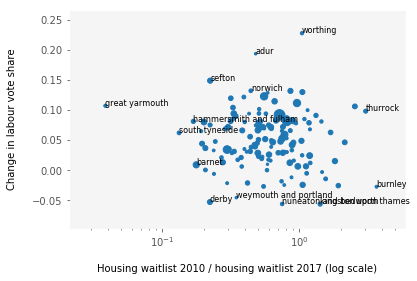

In [19]:
t = vote_share_change.join(waiting_list).join(total_population_by_authority)

plt.scatter(t['ratio'], t['labour_change'], s=t['population']/10000)

extremes = (list(t.sort_values('ratio').iloc[np.r_[0:4, -4:0]].index)
            + list(t.sort_values('labour_change').iloc[np.r_[0:4, -4:0]].index))
for i, r in t.loc[extremes].iterrows():
    if all(np.isfinite(t.loc[i, ['ratio', 'labour_change']])):
        plt.text(t.loc[i, 'ratio'], t.loc[i, 'labour_change'], i, fontsize=8)

plt.semilogx()
plt.xlabel("Housing waitlist 2010 / housing waitlist 2017 (log scale)")
plt.ylabel("Change in labour vote share")

In [20]:
model = pystan.StanModel(file="../stan/model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5daa3b0c2d33b5794e9a2a84452775e5 NOW.


In [21]:
predictors = ['waiting_list_ratio', 'median_income_2017', 'leave_vote_share']
model_input = {
    'N': len(dm),
    'M': len(predictors),
    'R': dm['region'].nunique(),
    'x': dm[predictors].astype(float),
    'region': dm['region_stan'],
    'y': dm['lab_2p_change']
}
fit = model.sampling(data=model_input, control={'adapt_delta':0.99})
samples = fit.to_dataframe()
samples.head()

,chain,chain_idx,warmup,divergent__,energy__,treedepth__,accept_stat__,stepsize__,n_leapfrog__,"b_z[1,1]",...,log_lik[116],log_lik[117],log_lik[118],log_lik[119],log_lik[120],log_lik[121],log_lik[122],log_lik[123],log_lik[124],lp__
0,1,1,0,0,-261.079640,6,0.986004,0.04602,127,-0.540068,...,2.224739,1.126469,2.124773,2.209640,2.213520,2.119654,2.229946,-4.260369,2.111857,280.887677
1,1,2,0,0,-268.603206,7,0.999311,0.04602,127,-0.401061,...,2.130304,-0.123121,1.974651,2.105457,1.846861,2.138500,2.138191,-4.020731,2.048584,290.805660
2,1,3,0,0,-271.540275,6,0.997412,0.04602,127,-1.673330,...,2.201237,-0.272497,2.201799,1.877741,2.181399,2.201917,2.167301,-7.240048,2.179250,287.748061
3,1,4,0,0,-262.861553,6,0.998818,0.04602,63,-1.737235,...,2.133715,1.656730,2.093534,2.135120,1.864284,2.026834,2.135956,-3.665382,1.698902,282.052592
4,1,5,0,0,-258.220449,6,0.995693,0.04602,63,-1.541239,...,1.984833,-0.212370,2.225603,2.217669,2.217597,2.219809,2.222034,-7.201554,2.085757,291.978828


In [22]:
print(fit.stansummary(pars=[p for p in fit.model_pars 
                            if p not in ['log_lik', 'y_tilde']
                            and 'z' not in p]))

Inference for Stan model: anon_model_5daa3b0c2d33b5794e9a2a84452775e5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_a      -3.4e-3  2.7e-4   0.01  -0.03-9.8e-3-2.9e-3 4.0e-3   0.02   1738    1.0
mu_b[1]    5.5e-3  2.1e-4 9.8e-3  -0.01-1.1e-3 4.6e-3   0.01   0.03   2189    1.0
mu_b[2]    9.8e-3  3.6e-4   0.01  -0.01 9.8e-4 8.2e-3   0.02   0.04   1597    1.0
mu_b[3]     -0.03  2.1e-4 9.3e-3  -0.05  -0.04  -0.03  -0.03  -0.02   2038    1.0
sigma_y      0.04  6.0e-5 3.1e-3   0.04   0.04   0.04   0.05   0.05   2675    1.0
sigma_a      0.02  3.4e-4   0.01 3.1e-3   0.01   0.02   0.03   0.05   1215    1.0
sigma_b[1]   0.02  2.3e-4   0.01 4.2e-3   0.01   0.02   0.02   0.04   1962    1.0
sigma_b[2]   0.02  5.5e-4   0.02 1.6e-3   0.01   0.02   0.03   0.07   1150    1.0
sigma_b[3]   0.01  2.4e-4 9.8e-3 5.3e-4 5.6e-3   0.01   0.02   0.04   168

In [23]:
region_stan_to_region = dm.groupby('region_stan')['region'].first()

In [24]:
b_samples = samples[[c for c in samples.columns if c[:2] == 'b[']].copy()
l = list(map(lambda s: s.strip('b[').strip(']').split(','), b_samples.columns))
b_samples.columns = pd.MultiIndex.from_tuples(
    [(predictors[int(i) - 1], region_stan_to_region.loc[int(j)]) for [i, j] in l]
)
print("Posterior mean effects by region:")
mean_regression_effects = b_samples.sort_index(axis=1).mean().unstack().T

mean_regression_effects.style.highlight_min(axis=0)

Posterior mean effects by region:


,leave_vote_share,median_income_2017,waiting_list_ratio
east midlands,-0.0342446,0.0248166,0.0114771
east of england,-0.0267695,0.0083738,0.0139694
london,-0.0220867,0.000755849,-0.00610216
north east,-0.0338335,0.0233505,0.00754018
north west,-0.0322011,0.0180256,-0.0113892
south east,-0.0289537,-0.01643,0.00800033
south west,-0.0328324,0.0214854,0.00955045
west midlands,-0.0394036,0.00543434,0.0111835
yorkshire and the humber,-0.033158,0.00541519,0.00454169


In [25]:
output = dm.copy()
ppc_samples = samples[[c for c in samples.columns if 'y_tilde' in c]].copy()
log_lik_samples = samples[[c for c in samples.columns if 'log_lik' in c]].copy()
output['log_likelihood_mean'] = log_lik_samples.mean().values
output['ppc_lower'] = ppc_samples.quantile(0.1).values
output['ppc_mean'] = ppc_samples.mean().values
output['ppc_upper'] = ppc_samples.quantile(0.9).values
log_lik_samples.mean().mean()

1.7286917542806621

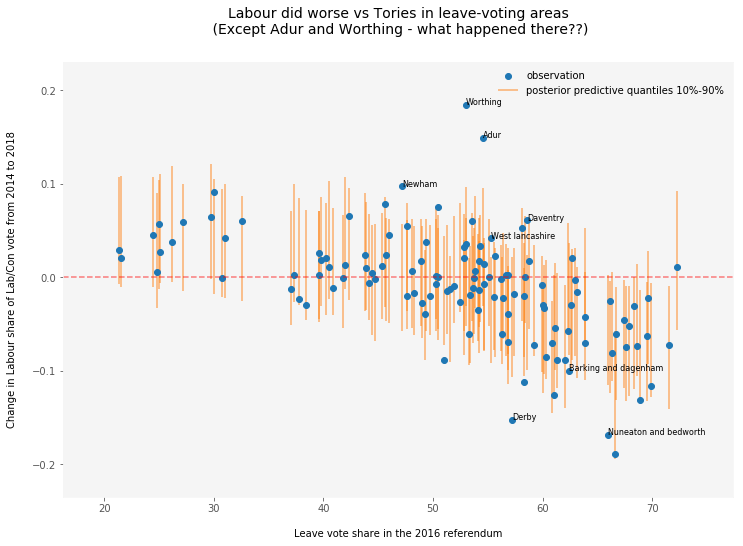

In [26]:
f, ax = plt.subplots(figsize=[12, 8])

x_col = 'leave_vote_share'

ax.scatter(output[x_col], output['lab_2p_change'], label='observation')
ax.vlines(output[x_col], output['ppc_lower'], output['ppc_upper'], 
          color='tab:orange', zorder=0, alpha=0.6, label='posterior predictive quantiles 10%-90%')
ax.axhline(0, color='r', linestyle='--', alpha=0.5)

extremes = list(output.sort_values('log_likelihood_mean')[:8].index)
for i, r in output.loc[extremes].iterrows():
    if all(np.isfinite(output.loc[i, [x_col, 'lab_2p_change']].astype(float))):
        plt.text(output.loc[i, x_col], output.loc[i, 'lab_2p_change'], i.capitalize(), fontsize=8)


ax.legend(frameon=False)
ax.set_xlabel('Leave vote share in the 2016 referendum')
ax.set_ylabel('Change in Labour share of Lab/Con vote from 2014 to 2018')
ax.set_title('Labour did worse vs Tories in leave-voting areas\n (Except Adur and Worthing - what happened there??)', fontsize=14)

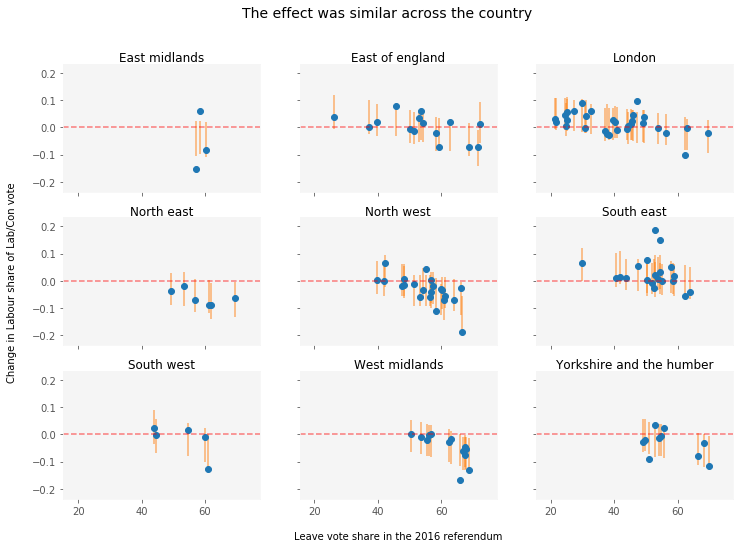

In [27]:
f, axes = plt.subplots(3, 3, figsize=[12, 8], sharex=True, sharey=True)
f.suptitle("The effect was similar across the country", fontsize=14)

axes = axes.ravel()
x_col = 'leave_vote_share'

for ax, (reg, df) in zip(axes, output.groupby('region')):
    ax.scatter(df[x_col], df['lab_2p_change'])
    ax.vlines(df[x_col], df['ppc_lower'], df['ppc_upper'], color='tab:orange', zorder=0, alpha=0.6)
    ax.axhline(0, color='r', linestyle='--', alpha=0.5)

    if ax == axes[3]:
        ax.set_ylabel('Change in Labour share of Lab/Con vote')
    if ax == axes[7]:
        ax.set_xlabel('Leave vote share in the 2016 referendum')
    ax.set_title(reg.capitalize(), y=0.8)

In [28]:
output.loc[lambda df: df['region'] == 'london'].sort_values('leave_vote_share')

,conservative_change,green_change,labour_change,libdem_change,other_change,ukip_change,lab_2p_change,waiting_list_2010,waiting_list_2017,waiting_list_change,...,median_income_2015,median_income_2016,median_income_2017,region,leave_vote_share,region_stan,log_likelihood_mean,ppc_lower,ppc_mean,ppc_upper
council,,,,,,,,,,,,,,,,,,,,,
lambeth,-0.023120,0.033513,0.006696,-0.006967,0.006920,-0.017041,0.029000,20988.0,20438.0,-550.0,...,28772,29317,31215,london,21.38,3,2.061959,-0.007706,0.049254,0.107012
hackney,-0.007984,-0.037295,0.049057,0.004468,-0.006291,-0.001955,0.020269,11956.0,12372.0,416.0,...,28739,28847,30000,london,21.52,3,1.957418,-0.010567,0.049577,0.107764
haringey,-0.020691,-0.050611,0.071998,0.031455,-0.022108,-0.010043,0.044713,16960.0,9194.0,-7766.0,...,27082,26477,28599,london,24.43,3,2.161848,-0.010146,0.048842,0.107240
islington,0.003276,-0.028390,0.046566,-0.022885,0.006269,-0.004836,0.005530,8426.0,18033.0,9607.0,...,33079,31680,33116,london,24.78,3,1.930857,-0.032579,0.029074,0.090262
wandsworth,-0.048277,-0.014317,0.048075,0.021734,0.015285,-0.022500,0.057034,6037.0,4400.0,-1637.0,...,35761,36538,36694,london,24.97,3,2.127175,-0.012685,0.045776,0.103649
camden,-0.007041,-0.055415,0.044403,0.024579,0.002242,-0.008767,0.026847,15213.0,2967.0,-12246.0,...,33429,33082,32597,london,25.06,3,2.001773,-0.006600,0.051813,0.110811
southwark,-0.029756,-0.011197,0.071772,0.010866,-0.012229,-0.029456,0.058537,10769.0,6665.0,-4104.0,...,29980,30000,30608,london,27.19,3,2.117193,-0.014659,0.042651,0.099916
hammersmith and fulham,-0.078718,-0.020118,0.081293,0.034755,-0.003824,-0.013388,0.090676,9361.0,1577.0,-7784.0,...,34438,34685,36018,london,29.98,3,1.537362,-0.017689,0.043611,0.104607
richmond upon thames,-0.073898,-0.014924,-0.020932,0.149100,-0.002662,-0.036685,-0.000622,7331.0,3068.0,-4263.0,...,35000,37704,36258,london,30.71,3,1.733176,-0.021426,0.037536,0.094631


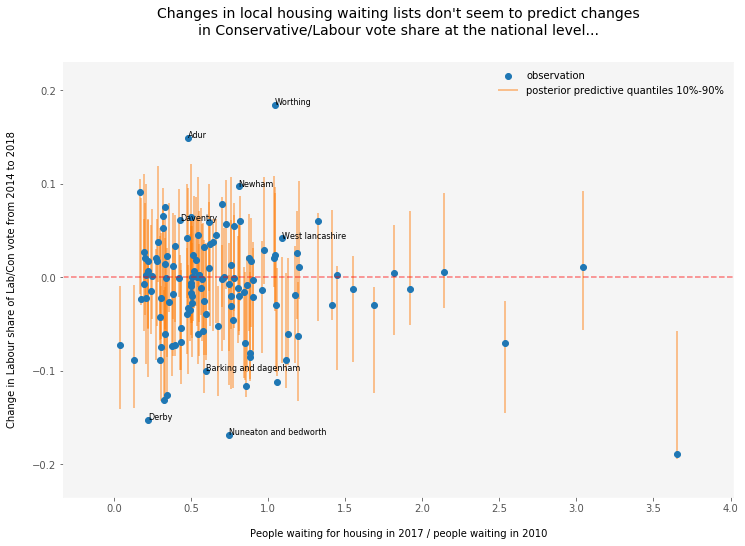

In [29]:
f, ax = plt.subplots(figsize=[12, 8])

x_col = 'waiting_list_ratio'

ax.scatter(output[x_col], output['lab_2p_change'], label='observation')
ax.vlines(output[x_col], output['ppc_lower'], output['ppc_upper'], 
          color='tab:orange', zorder=0, alpha=0.6, label='posterior predictive quantiles 10%-90%')
ax.axhline(0, color='r', linestyle='--', alpha=0.5)

extremes = list(output.sort_values('log_likelihood_mean')[:8].index)
for i, r in output.loc[extremes].iterrows():
    if all(np.isfinite(output.loc[i, [x_col, 'lab_2p_change']].astype(float))):
        plt.text(output.loc[i, x_col], output.loc[i, 'lab_2p_change'], i.capitalize(), fontsize=8)


ax.legend(frameon=False)
ax.set_xlabel('People waiting for housing in 2017 / people waiting in 2010')
ax.set_ylabel('Change in Labour share of Lab/Con vote from 2014 to 2018')
ax.set_title("Changes in local housing waiting lists don't seem to predict changes\n"
             "in Conservative/Labour vote share at the national level...", fontsize=14)



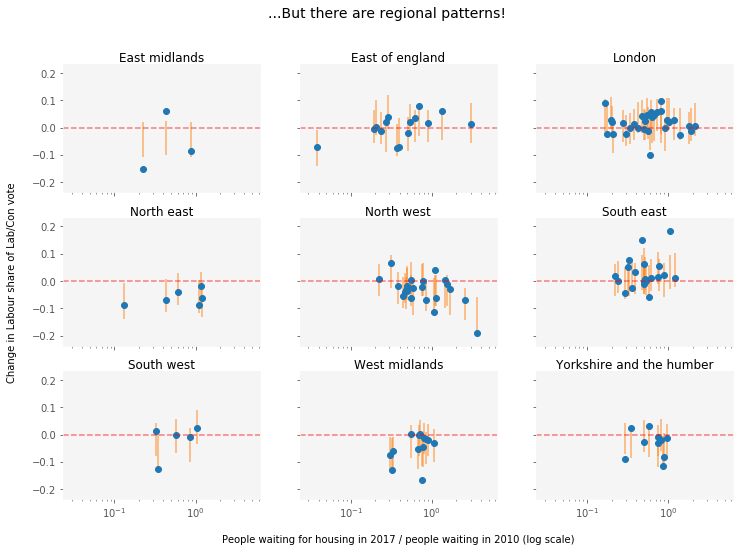

In [30]:
f, axes = plt.subplots(3, 3, figsize=[12, 8], sharex=True, sharey=True)
f.suptitle("...But there are regional patterns!", fontsize=14)

axes = axes.ravel()
x_col = 'waiting_list_ratio'

for ax, (reg, df) in zip(axes, output.groupby('region')):
    ax.scatter(df[x_col], df['lab_2p_change'])
    ax.vlines(df[x_col], df['ppc_lower'], df['ppc_upper'], color='tab:orange', zorder=0, alpha=0.6)
    ax.axhline(0, color='r', linestyle='--', alpha=0.5)

    ax.semilogx()

    if ax == axes[3]:
        ax.set_ylabel('Change in Labour share of Lab/Con vote')
    if ax == axes[7]:
        ax.set_xlabel('People waiting for housing in 2017 / people waiting in 2010 (log scale)')
    ax.set_title(reg.capitalize(), y=0.8)

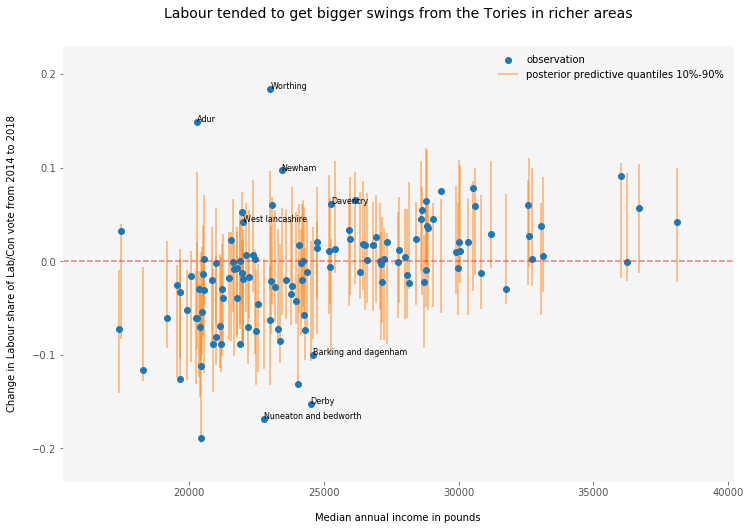

In [31]:
f, ax = plt.subplots(figsize=[12, 8])

x_col = 'median_income_2017'

ax.scatter(output[x_col], output['lab_2p_change'], label='observation')
ax.vlines(output[x_col], output['ppc_lower'], output['ppc_upper'], 
          color='tab:orange', zorder=0, alpha=0.6, label='posterior predictive quantiles 10%-90%')
ax.axhline(0, color='r', linestyle='--', alpha=0.5)

extremes = list(output.sort_values('log_likelihood_mean')[:8].index)
for i, r in output.loc[extremes].iterrows():
    if all(np.isfinite(output.loc[i, [x_col, 'lab_2p_change']].astype(float))):
        plt.text(output.loc[i, x_col], output.loc[i, 'lab_2p_change'], i.capitalize(), fontsize=8)


ax.legend(frameon=False)
ax.set_xlabel('Median annual income in pounds')
ax.set_ylabel('Change in Labour share of Lab/Con vote from 2014 to 2018')
ax.set_title("Labour tended to get bigger swings from the Tories in richer areas", fontsize=14)



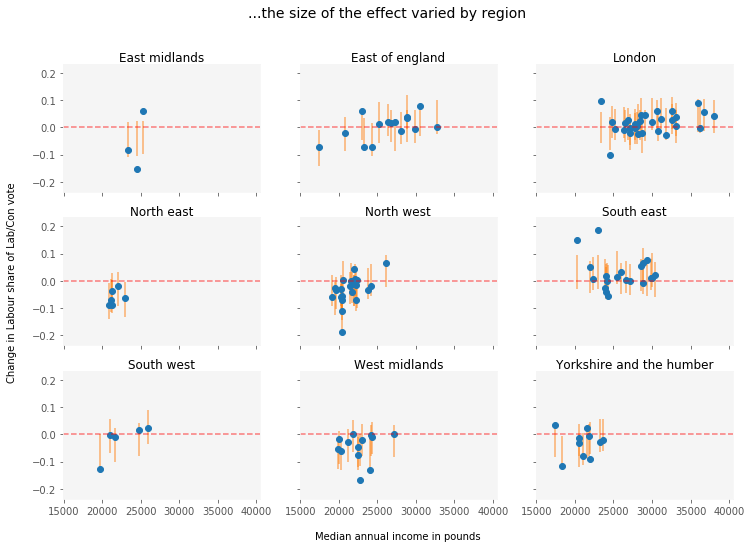

In [32]:
f, axes = plt.subplots(3, 3, figsize=[12, 8], sharex=True, sharey=True)
f.suptitle("...the size of the effect varied by region", fontsize=14)

axes = axes.ravel()
x_col = 'median_income_2017'

for ax, (reg, df) in zip(axes, output.groupby('region')):
    ax.scatter(df[x_col], df['lab_2p_change'])
    ax.vlines(df[x_col], df['ppc_lower'], df['ppc_upper'], color='tab:orange', zorder=0, alpha=0.6)
    ax.axhline(0, color='r', linestyle='--', alpha=0.5)
    if ax == axes[3]:
        ax.set_ylabel('Change in Labour share of Lab/Con vote')
    if ax == axes[7]:
        ax.set_xlabel('Median annual income in pounds')
    ax.set_title(reg.capitalize(), y=0.8)